In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
import pandas as pd
import numpy as np

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train = train.drop(labels = ["label"],axis = 1)
y_train = train["label"]
train.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [7]:
#Normalization
X_train = X_train / 255.0
test = test / 255.0


In [8]:
#Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

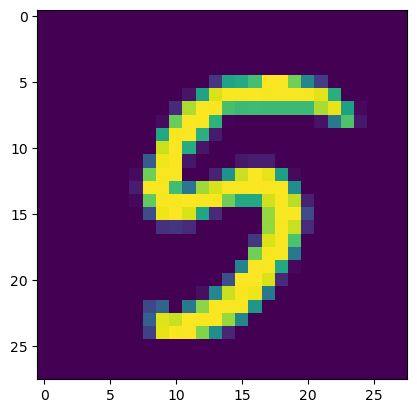

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
g = plt.imshow(X_train[8][:,:,0])

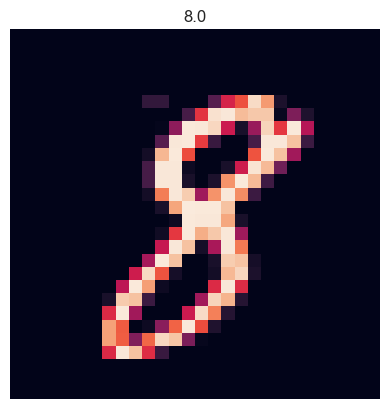

In [65]:
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Loading data
train = pd.read_csv("data/train.csv",dtype = np.float32)

# Splitting data into features and labels
y_numpy = train.label.values
X_numpy = train.loc[:,train.columns != "label"].values
X_numpy_normalized = X_numpy / 255.

# train test split.
X_train, X_test, y_train, y_test = train_test_split(X_numpy_normalized, y_numpy, test_size = 0.2, random_state = 42)

# Converting the data into tensors
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 1000
n_iters = 10000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test,y_test)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualizing one of the image in the training set
plt.imshow(X_numpy[20].reshape(28,28))
plt.axis("off")
plt.title(str(y_numpy[20]))
plt.show()

In [50]:
import torch.nn as nn
class ArtificialNeuralNetwork(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ArtificialNeuralNetwork, self).__init__()

        # Layer1: 784 --> 150
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()

        # Layer2: 150 --> 150
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.tanh2 = nn.Tanh()

        # Layer3: 150 --> 150
        #self.l3 = nn.Linear(hidden_dim, hidden_dim)
        #self.elu3 = nn.ELU()

        # Layer4 (readout): 150 --> 10
        self.l4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Layer 1
        out = self.l1(x)
        out = self.relu1(out)

        # Layer 2
        out = self.l2(out)
        out = self.tanh2(out)

        # Layer 3
        #out = self.l3(out)
        #out = self.elu3(out)

        # Layer 4 (readout)
        out = self.l4(out)
        return out



input_dim = 28*28
hidden_dim = 150 # Hyperparameter (hidden layer size)
output_dim = 10

model = ArtificialNeuralNetwork(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [46]:
num_epochs = 10

In [55]:
count = 0
cost = []
iteration_list = []
accuracy_list = []
model.cuda()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.reshape(-1, 28*28)
        images = images.to(0)
        labels = labels.to(0)
        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(images)

        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)

        # Calculating gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        count += 1

        if count % 50 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:

                test = images.reshape(-1, 28*28)
                test = test.to(0)

                labels = labels.to(0)
                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                # Total number of labels
                total += len(labels)
                predicted, labels = predicted.cpu(), labels.cpu()
                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            cost.append(loss.cpu().data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.0298164002597332  Accuracy: 96.83333587646484 %
Iteration: 1000  Loss: 0.057311251759529114  Accuracy: 96.8452377319336 %
Iteration: 1500  Loss: 0.037729740142822266  Accuracy: 96.8452377319336 %
Iteration: 2000  Loss: 0.04793170467019081  Accuracy: 96.83333587646484 %
Iteration: 2500  Loss: 0.03509668633341789  Accuracy: 96.91666412353516 %
Iteration: 3000  Loss: 0.032832346856594086  Accuracy: 96.92857360839844 %
Iteration: 3500  Loss: 0.027675427496433258  Accuracy: 96.89286041259766 %
Iteration: 4000  Loss: 0.029352393001317978  Accuracy: 96.96428680419922 %
Iteration: 4500  Loss: 0.03532864898443222  Accuracy: 96.9047622680664 %
Iteration: 5000  Loss: 0.02310601808130741  Accuracy: 96.96428680419922 %
Iteration: 5500  Loss: 0.026690028607845306  Accuracy: 97.02381134033203 %
Iteration: 6000  Loss: 0.026732701808214188  Accuracy: 97.07142639160156 %
Iteration: 6500  Loss: 0.034774959087371826  Accuracy: 97.08333587646484 %
Iteration: 7000  Loss: 0.0288052223

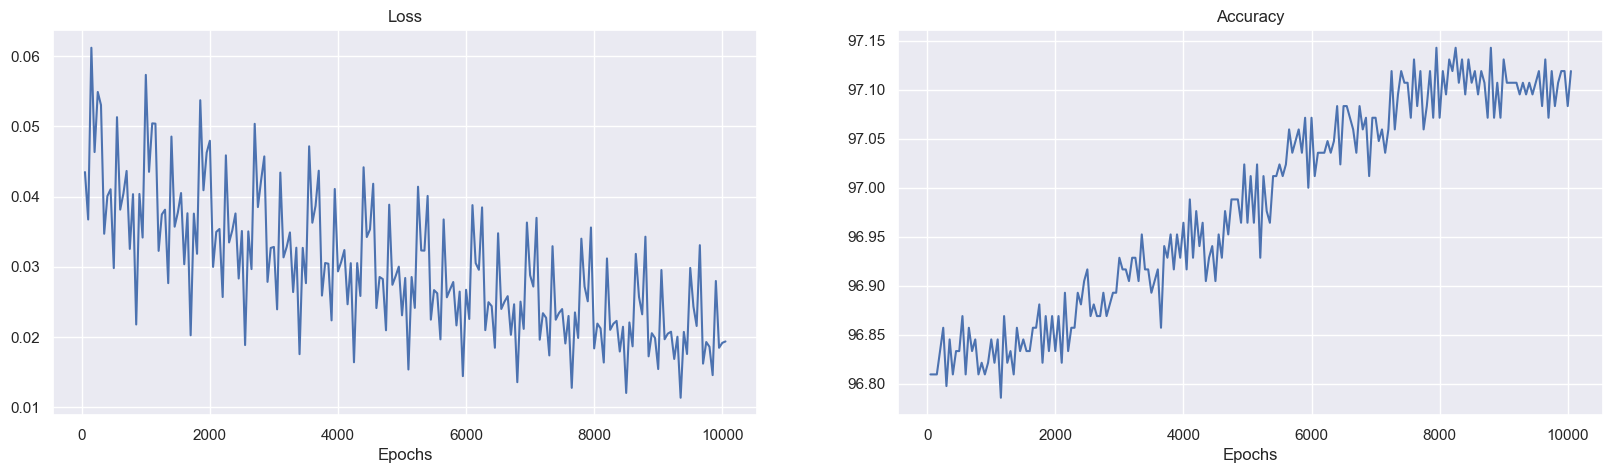

In [56]:
from torch import Tensor
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

# Plotting loss
ax1 = sns.lineplot(x = iteration_list, y = np.array(cost), ax= ax[0])
ax1.set(title = 'Loss', xlabel = 'Epochs')

# Plotting accuracy
ax2 = sns.lineplot(x = iteration_list, y = np.array(accuracy_list), ax= ax[1])
ax2.set(title = 'Accuracy', xlabel = 'Epochs');

In [73]:
test2 = pd.read_csv("data/test.csv",dtype = np.float32)
#X_numpy = train.loc[:,train.columns != "label"].values
#X_numpy_normalized = X_numpy / 255.
X_t = test2.values
X_t_normalized = X_t / 255.
test = torch.from_numpy(X_t_normalized)
len(test)

28000

In [76]:
# predicting the results
#test.to(0)
model.cpu()
results = model(test)
results = results.cpu()
# selecting the indix with the maximum probability
results = torch.max(results.data, 1)[1]
print(results)
results = pd.Series(results,name="Label")



submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission.csv",index=False)

tensor([2, 0, 9,  ..., 3, 9, 2])
